In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import re
import utils
import tensorflow as tf
from tensorflow import keras
import keras
from glob import glob

In [2]:
TRAIN_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/train'
OUTPUT_SHAPE = (256, 256)
THRESHOLD = 5

# File paths to load JSON files
TRAIN_ANNOTATIONS_ORIGINAL = 'DeepRuleDataset/bardata(1031)/bar/annotations/instancesBar(1031)_train2019.json'
VAL_ANNOTATIONS_ORIGINAL = 'DeepRuleDataset/bardata(1031)/bar/annotations/instancesBar(1031)_val2019.json'
# File paths to load bar images
TRAIN_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/train2019'
VAL_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/val2019'
#CBSL images
CBSL_IMAGES = 'CBSLDataset/charts'

with open(TRAIN_ANNOTATIONS_ORIGINAL) as f:
        train_annotations = json.load(f)
with open(VAL_ANNOTATIONS_ORIGINAL) as f:
        val_annotations = json.load(f)

train_images = train_annotations['images']
val_images = val_annotations['images']

In [3]:
index = 0
cbsl_images = sorted(glob(pathname='*.png', root_dir=CBSL_IMAGES))
file_name = cbsl_images[index]
file_path = os.path.join(CBSL_IMAGES, file_name)
file_path

'CBSLDataset/charts/bar_0001.png'

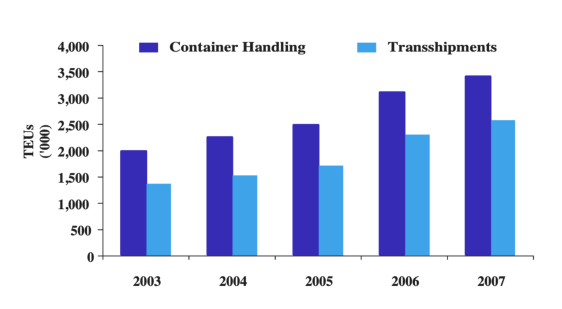

In [4]:
# index = 47
# file_name = train_images[index]['file_name']
# file_path = os.path.join(TRAIN_PATH_BAR, file_name)

index = 18
cbsl_images = sorted(glob(pathname='*.png', root_dir=CBSL_IMAGES))
file_name = cbsl_images[index]
file_path = os.path.join(CBSL_IMAGES, file_name)

rgb = cv2.imread(file_path, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(rgb)
ax.axis('off')
plt.show()

In [5]:
y_axis_line, line_image = utils.extract_y_axis(file_path)

Y-Axis Line Coordinates: ((219, 594), (219, 85))


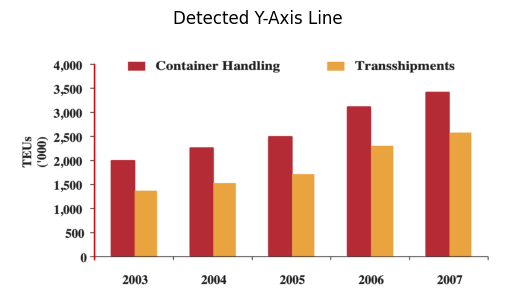

In [6]:
# Display the image with detected lines
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Y-Axis Line')
plt.axis('off')
plt.show()

In [7]:
def is_floating_point(number_str):
    try:
        float(number_str)
        return '.' in number_str
    except ValueError:
        return False

def find_min_max(txt):
    txt = txt.replace(',', '')
    splits = txt.split('\n')
    numbers_and_spaces = [re.sub(r'[^0-9 .]', '', item) for item in splits]
    numbers = [value.strip() for value in numbers_and_spaces]
    numbers_only = [int(float(num)) for num in numbers if num.isdigit() or is_floating_point(num)]
    return (min(numbers_only), max(numbers_only))

In [8]:
def is_floating_point(number_str):
    """
    Checks if a given string represents a floating point number.
    Args:
    number_str (str): The string to check.
    Returns:
    bool: True if the string represents a floating point number, False otherwise.
    """
    try:
        float(number_str)
        return '.' in number_str
    except ValueError:
        return False

def find_min_max(txt):
    txt = txt.replace(',', '')
    splits = txt.split('\n')
    numbers_and_spaces = [re.sub(r'[^0-9 .]', '', item) for item in splits]
    numbers = [value.strip() for value in numbers_and_spaces]
    numbers_only = [int(float(num)) for num in numbers if num.isdigit() or is_floating_point(num)]
    return (min(numbers_only), max(numbers_only))

In [17]:
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
txt = utils.extract_text(gray, y_axis_line)
try:
    y_min, y_max = find_min_max(txt)
except ValueError:
    y_min, y_max = 'Minimum y value not found', 'Maximum y value not found'

print(f'Extracted values: \ny_min - {y_min} \ny_max - {y_max}')

Extracted values: 
y_min - 500 
y_max - 4000


In [10]:
txt

'4,000 -\n3,500 -\n3,000 -\n\n3g 2500 -\nZS 2000 -\n\n1,500 -\n1,000 -\n500 -\no-'

In [11]:
from tensorflow.keras.models import load_model
from keras.losses import BinaryCrossentropy, Huber

@tf.keras.utils.register_keras_serializable()
def keypoint_loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    huber = Huber(delta=1.0)
    return bce(y_true, y_pred) + huber(y_true, y_pred)

stacked_hourglass = load_model('SavedModels/key-point-detector-epoch-1.keras')
# image_paths = [os.path.join(TRAIN_PATH_BAR, image['file_name']) for image in train_images[40:48]]

image_paths = [os.path.join(CBSL_IMAGES, image) for image in cbsl_images[0:32]]

X = np.array([cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), OUTPUT_SHAPE) for path in image_paths])
predictions = stacked_hourglass.predict(X)

I0000 00:00:1721643553.077096   86023 service.cc:145] XLA service 0x600002dd0600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721643553.077315   86023 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-22 15:49:13.135082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721643553.973364   86023 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 193s 193s/step


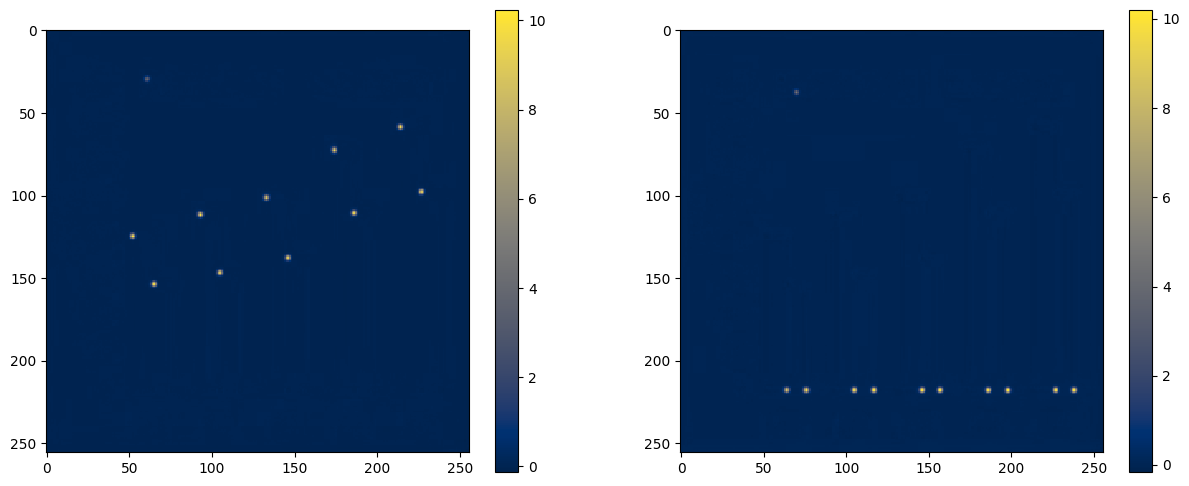

In [12]:
# index = 7
predicted_heatmap = predictions[index]
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
img1 = axes[0].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(predicted_heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

In [15]:
# load two batches of train heatmaps
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))[5:6]
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
train_heatmaps = np.concatenate([np.load(heatmap)['batch'] for heatmap in train_heatmaps], axis=0)
heatmap = train_heatmaps[index]
fig, axes = plt.subplots(1, 2, figsize=(100, 100))
img1 = axes[0].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[0], cmap='cividis',interpolation='nearest')
img2 = axes[1].imshow(tf.transpose(heatmap, perm=[2, 0, 1])[1], cmap='cividis',interpolation='nearest')
fig.colorbar(img1, ax=axes[0], shrink=0.4)
fig.colorbar(img2, ax=axes[1], shrink=0.4)
plt.show()

IndexError: index 18 is out of bounds for axis 0 with size 8

In [13]:
THRESHOLD = 5

In [14]:
input_img_height = rgb.shape[0]
heatmap_height = OUTPUT_SHAPE[0]
scaling_factor = utils.calculate_scaling_factor(input_img_height, heatmap_height, y_axis_line, y_max)

centroids = utils.extract_centroids(predicted_heatmap,threshold=THRESHOLD)
matched_coordinates = utils.match_bar_coordinates(centroids)
extracted_bar_values = utils.bar_values(matched_coordinates, scaling_factor)    

In [15]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Bar', 'Value']
for index, value in enumerate(extracted_bar_values):
    table.add_row([f' Bar {str(index+1).zfill(2)}', value])
print(table)

+---------+-------+
|   Bar   | Value |
+---------+-------+
|  Bar 01 |  1964 |
|  Bar 02 |  1331 |
|  Bar 03 |  2218 |
|  Bar 04 |  1500 |
|  Bar 05 |  2450 |
|  Bar 06 |  1668 |
|  Bar 07 |  3083 |
|  Bar 08 |  2260 |
|  Bar 09 |  3337 |
|  Bar 10 |  2534 |
+---------+-------+
